In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                             calinski_harabasz_score, davies_bouldin_score)
from sklearn.neighbors import NearestNeighbors
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [4]:
#  LOAD DATA AND MODELS
df = pd.read_csv('D:\My projects\customer_segmentation_project\data\processed\step5_dimensionality_reduced.csv')
print(f"✓ Loaded data: {df.shape}")

# Load the KMeans model
with open('D:\My projects\customer_segmentation_project\outputs\models\kmeans_model.pkl', 'rb') as f:
    kmeans_model = pickle.load(f)
print(f"✓ Loaded KMeans model with {kmeans_model.n_clusters} clusters")

# Load the scaler
with open('D:\My projects\customer_segmentation_project\outputs\models\scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print("✓ Loaded scaler")
df.columns

✓ Loaded data: (2229, 74)
✓ Loaded KMeans model with 2 clusters
✓ Loaded scaler


Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Total_Spending', 'Total_Purchases', 'Children',
       'Customer_Tenure_Days', 'R_Value', 'F_Value', 'M_Value', 'R_Score',
       'F_Score', 'M_Score', 'RFM_Segment', 'RFM_Score', 'Customer_Segment',
       'Education_Level', 'Family_Size', 'Has_Children', 'Avg_Order_Value',
       'Purchase_Frequency_Rate', 'Wine_Ratio', 'Meat_Ratio',
       'Product_Diversity', 'Premium_Product_Ratio', 'Web_Purchase_Ratio',
       'Store_Purchase_Ratio', 'Campaign_Acceptance_Rate', 'Has_Complained'

In [5]:
# PREPARE FEATURES
features_for_clustering = [
    # RFM Metrics (3)
    'R_Score', 'F_Score', 'M_Score',
    
    # Demographics (5)
    'Age', 'Income', 'Education_Level', 'Family_Size', 'Has_Children',
    
    # Spending Behavior (3)
    'Avg_Order_Value', 'Purchase_Frequency_Rate', 'Customer_Tenure_Days',
    
    # Product Preferences (4)
    'Wine_Ratio', 'Meat_Ratio', 'Product_Diversity', 'Premium_Product_Ratio',
    
    # Channel Preferences (2)
    'Web_Purchase_Ratio', 'Store_Purchase_Ratio',
    
    # Engagement (4)
    'Campaign_Acceptance_Rate', 'NumWebVisitsMonth', 'Has_Complained', 'Engagement_Score',
    
    # Value Metrics (2)
    'CLV_Estimate', 'Customer_Value_Score',
    
    # Binary Flags (5)
    'Is_High_Spender', 'Is_Active', 'Is_Campaign_Responder', 
    'Is_Web_Shopper', 'Is_Deal_Seeker'
]

# Verify all features exist
available_features = [f for f in features_for_clustering if f in df.columns]
missing_features = [f for f in features_for_clustering if f not in df.columns]

if missing_features:
    print(f"⚠ Warning: Missing features: {missing_features}")
    feature_cols = available_features
else:
    feature_cols = features_for_clustering

print(f"✓ Using {len(feature_cols)} features for evaluation")
print(f"  - RFM Metrics: 3")
print(f"  - Demographics: 5")
print(f"  - Spending Behavior: 3")
print(f"  - Product Preferences: 4")
print(f"  - Channel Preferences: 2")
print(f"  - Engagement: 4")
print(f"  - Value Metrics: 2")
print(f"  - Binary Flags: 5")

# Get scaled features and clusters
X_scaled = df[feature_cols].values
clusters = df['Final_ML_Cluster'].values
n_clusters = len(np.unique(clusters))

print(f"✓ Number of clusters: {n_clusters}")

✓ Using 28 features for evaluation
  - RFM Metrics: 3
  - Demographics: 5
  - Spending Behavior: 3
  - Product Preferences: 4
  - Channel Preferences: 2
  - Engagement: 4
  - Value Metrics: 2
  - Binary Flags: 5
✓ Number of clusters: 2


In [6]:
# CLUSTERING EVALUATION METRICS
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print("  → Measures: How similar objects are to their own cluster vs other clusters")
print("  → Range: [-1, 1] | Optimal: Close to 1")
print("  → Interpretation: ", end="")
if silhouette_avg > 0.7:
    print("Excellent - Strong cluster structure")
elif silhouette_avg > 0.5:
    print("Good - Reasonable cluster structure")
elif silhouette_avg > 0.25:
    print("Fair - Weak cluster structure")
else:
    print("Poor - Clusters may be overlapping")


Silhouette Score: 0.3975
  → Measures: How similar objects are to their own cluster vs other clusters
  → Range: [-1, 1] | Optimal: Close to 1
  → Interpretation: Fair - Weak cluster structure


In [7]:
calinski_score = calinski_harabasz_score(X_scaled, clusters)
print(f"Calinski-Harabasz Score: {calinski_score:.2f}")
print("  → Measures: Ratio of between-cluster to within-cluster variance")
print("  → Range: [0, ∞] | Optimal: Higher is better")
print("  → Interpretation: ", end="")
if calinski_score > 1000:
    print("Excellent - Well-separated clusters")
elif calinski_score > 500:
    print("Good - Adequately separated clusters")
else:
    print("Fair - Some cluster overlap")

Calinski-Harabasz Score: 2064.24
  → Measures: Ratio of between-cluster to within-cluster variance
  → Range: [0, ∞] | Optimal: Higher is better
  → Interpretation: Excellent - Well-separated clusters


In [8]:
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
print("  → Measures: Average similarity between each cluster and its most similar one")
print("  → Range: [0, ∞] | Optimal: Close to 0")
print("  → Interpretation: ", end="")
if davies_bouldin < 0.5:
    print("Excellent - Very distinct clusters")
elif davies_bouldin < 1.0:
    print("Good - Well-separated clusters")
elif davies_bouldin < 1.5:
    print("Fair - Moderate separation")
else:
    print("Poor - Significant overlap")


Davies-Bouldin Score: 0.7016
  → Measures: Average similarity between each cluster and its most similar one
  → Range: [0, ∞] | Optimal: Close to 0
  → Interpretation: Good - Well-separated clusters


In [9]:
inertia = kmeans_model.inertia_
print(f"Inertia (WCSS): {inertia:.2f}")
print("  → Measures: Sum of squared distances to nearest cluster center")
print("  → Interpretation: Lower is better (but consider in context of other metrics)")

Inertia (WCSS): 49351.15
  → Measures: Sum of squared distances to nearest cluster center
  → Interpretation: Lower is better (but consider in context of other metrics)


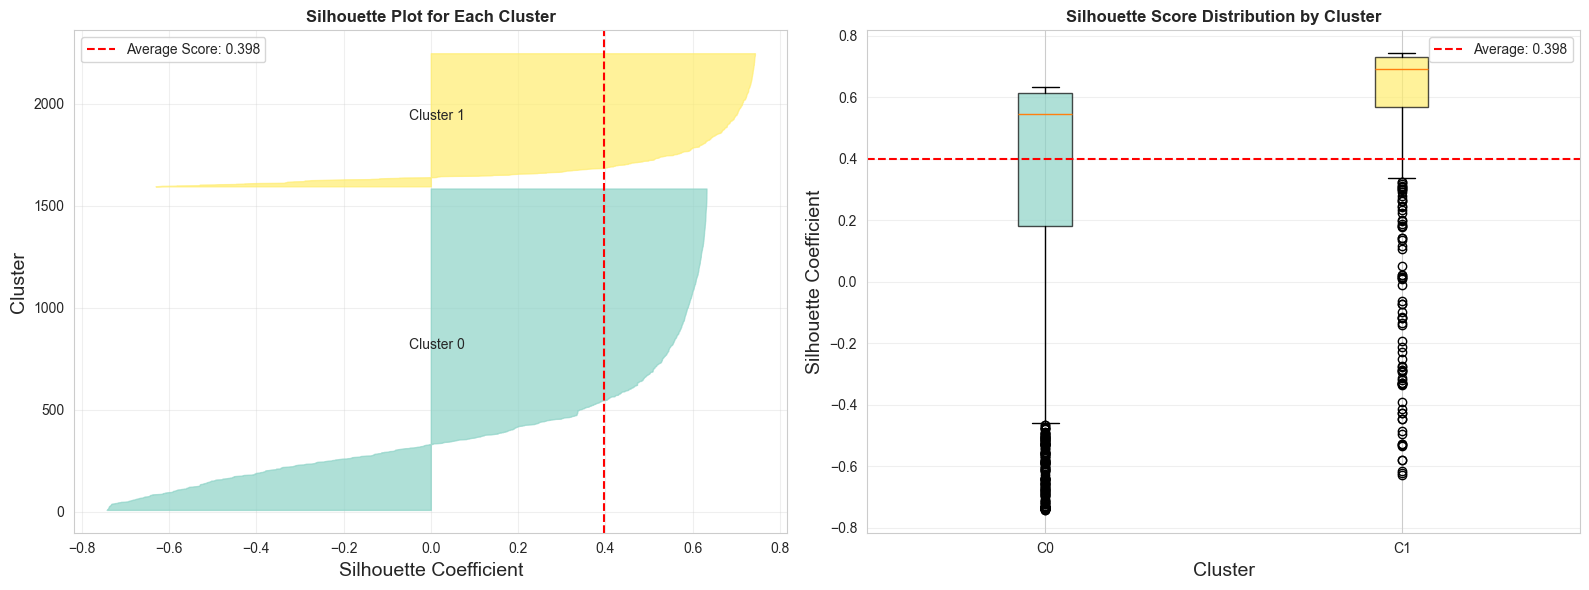


Cluster-wise Silhouette Scores:
----------------------------------------------------------------------
Cluster 0:
  Mean: 0.3258
  Std:  0.4148
  Min:  -0.7426
  Max:  0.6316
  Samples below avg: 539 (34.2%)

Cluster 1:
  Mean: 0.5707
  Std:  0.2858
  Min:  -0.6306
  Max:  0.7427
  Samples below avg: 91 (13.9%)



In [10]:
# SILHOUETTE ANALYSIS
silhouette_vals = silhouette_samples(X_scaled, clusters)

# Create silhouette plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Silhouette plot
y_lower = 10
colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

ax1.set_xlabel('Silhouette Coefficient')
ax1.set_ylabel('Cluster')
ax1.set_title('Silhouette Plot for Each Cluster', fontweight='bold', fontsize=12)
ax1.axvline(x=silhouette_avg, color='red', linestyle='--', 
            label=f'Average Score: {silhouette_avg:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Silhouette score distribution by cluster
silhouette_by_cluster = [silhouette_vals[clusters == i] for i in range(n_clusters)]
bp = ax2.boxplot(silhouette_by_cluster, labels=[f'C{i}' for i in range(n_clusters)],
                 patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.axhline(y=silhouette_avg, color='red', linestyle='--', 
            label=f'Average: {silhouette_avg:.3f}')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Silhouette Coefficient')
ax2.set_title('Silhouette Score Distribution by Cluster', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_silhouette_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Print cluster-wise silhouette scores
print("\nCluster-wise Silhouette Scores:")
print("-" * 70)
for i in range(n_clusters):
    cluster_sil = silhouette_vals[clusters == i]
    print(f"Cluster {i}:")
    print(f"  Mean: {cluster_sil.mean():.4f}")
    print(f"  Std:  {cluster_sil.std():.4f}")
    print(f"  Min:  {cluster_sil.min():.4f}")
    print(f"  Max:  {cluster_sil.max():.4f}")
    print(f"  Samples below avg: {(cluster_sil < silhouette_avg).sum()} "
          f"({(cluster_sil < silhouette_avg).sum()/len(cluster_sil)*100:.1f}%)")
    print()

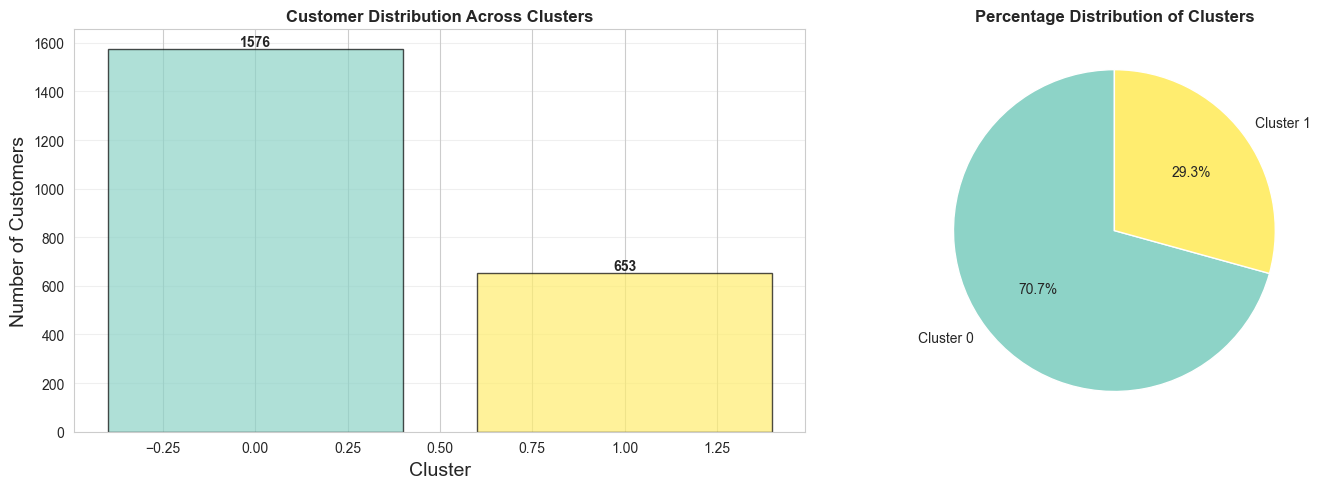


Cluster Balance Metrics:
----------------------------------------------------------------------
Largest cluster: 1576 customers (70.7%)
Smallest cluster: 653 customers (29.3%)
Average cluster size: 1114 customers
Balance ratio (min/max): 0.41
Standard deviation: 652.7

⚠ Clusters show moderate imbalance


In [12]:
# CLUSTER SIZE AND BALANCE ANALYSIS
cluster_sizes = pd.Series(clusters).value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cluster sizes (bar chart)
bars = ax1.bar(cluster_sizes.index, cluster_sizes.values, 
               color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Customer Distribution Across Clusters', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Cluster sizes (pie chart)
ax2.pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Percentage Distribution of Clusters', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_cluster_distribution.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Calculate balance metrics
print("\nCluster Balance Metrics:")
print("-" * 70)
max_size = cluster_sizes.max()
min_size = cluster_sizes.min()
avg_size = cluster_sizes.mean()
balance_ratio = min_size / max_size

print(f"Largest cluster: {max_size} customers ({max_size/len(df)*100:.1f}%)")
print(f"Smallest cluster: {min_size} customers ({min_size/len(df)*100:.1f}%)")
print(f"Average cluster size: {avg_size:.0f} customers")
print(f"Balance ratio (min/max): {balance_ratio:.2f}")
print(f"Standard deviation: {cluster_sizes.std():.1f}")

if balance_ratio > 0.5:
    print("\n✓ Clusters are well-balanced")
elif balance_ratio > 0.25:
    print("\n⚠ Clusters show moderate imbalance")
else:
    print("\n⚠ Clusters are significantly imbalanced - consider reviewing")

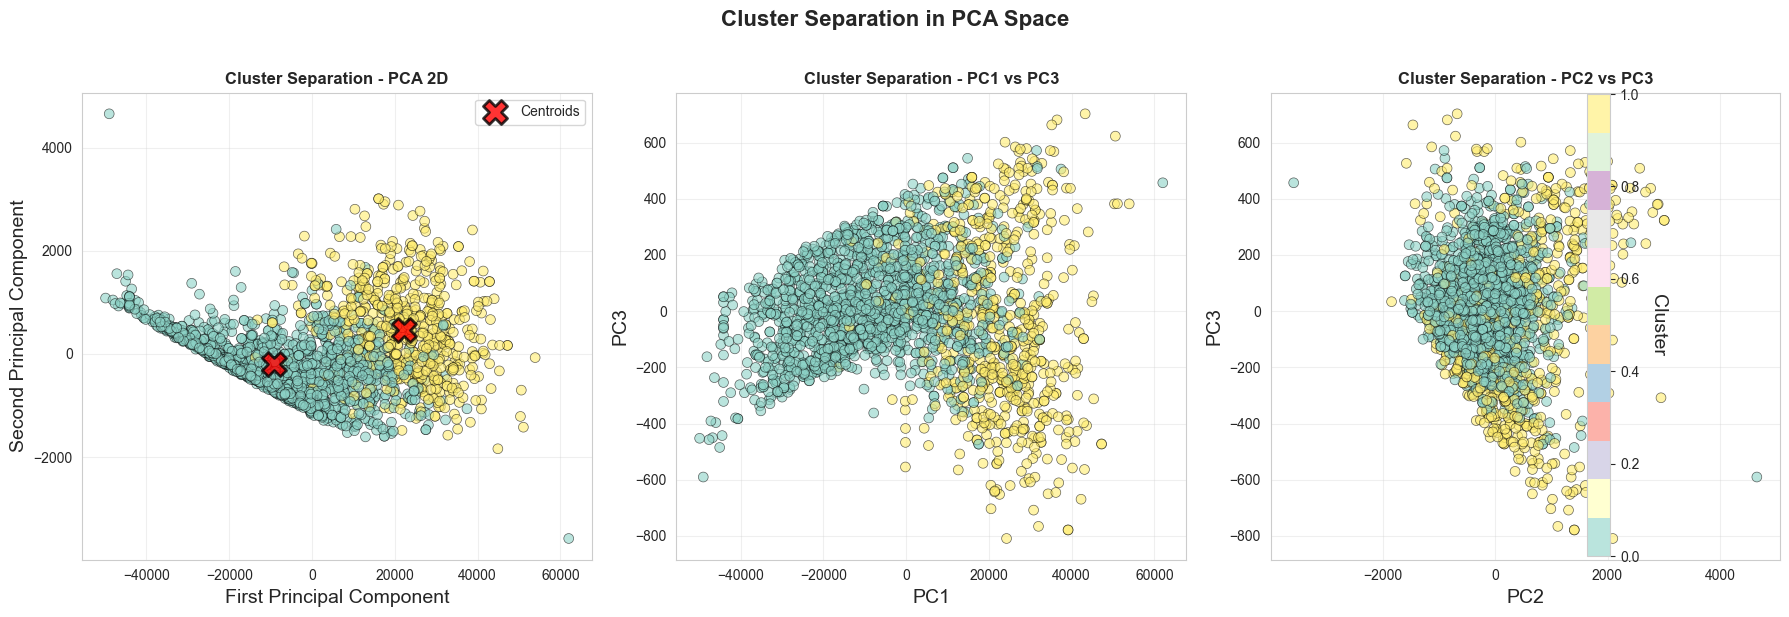

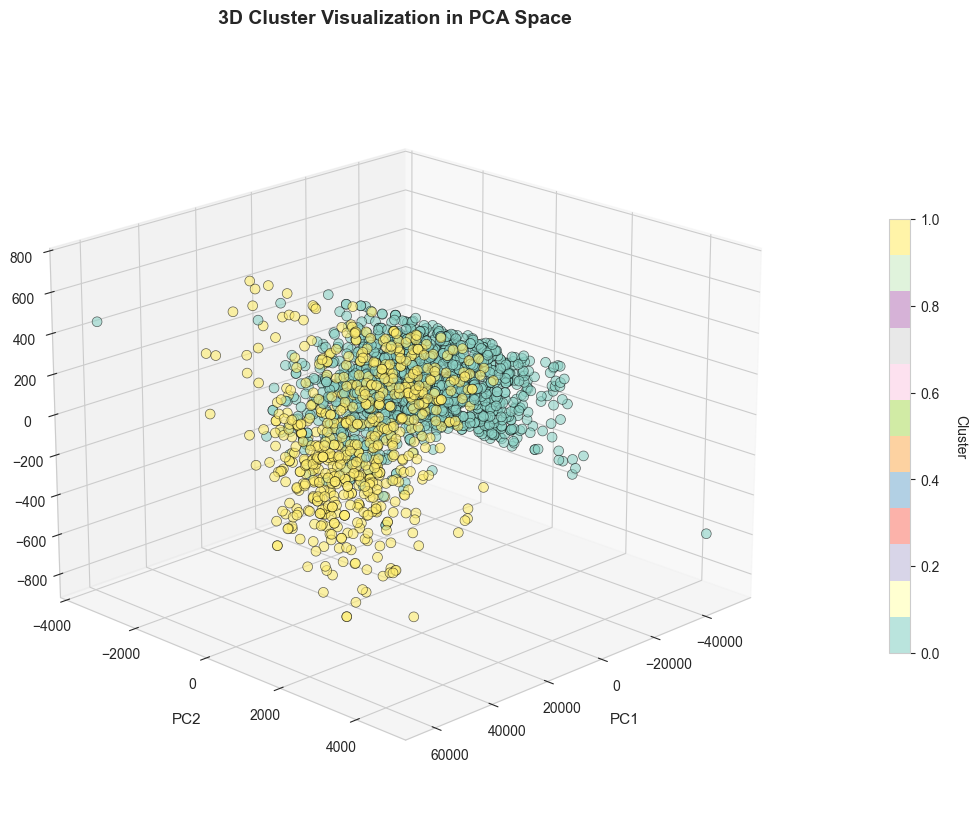

In [14]:
# CLUSTER SEPARATION VISUALIZATION (PCA)
if 'PCA1' in df.columns and 'PCA2' in df.columns:
    # Create visualization with PCA projections
    fig = plt.figure(figsize=(18, 6))

    # PCA 2D
    ax1 = fig.add_subplot(131)
    scatter1 = ax1.scatter(df['PCA1'], df['PCA2'], c=clusters, 
                           cmap='Set3', s=50, alpha=0.6, 
                           edgecolors='black', linewidth=0.5)
    ax1.set_xlabel('First Principal Component')
    ax1.set_ylabel('Second Principal Component')
    ax1.set_title('Cluster Separation - PCA 2D', fontweight='bold', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add cluster centers in PCA space
    centers_pca = np.array([df[df['Final_ML_Cluster'] == i][['PCA1', 'PCA2']].mean() 
                            for i in range(n_clusters)])
    ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                c='red', s=300, alpha=0.8, edgecolors='black', 
                linewidth=2, marker='X', label='Centroids')
    ax1.legend()

    # Check for 3D PCA components
    if 'PCA1_3D' in df.columns and 'PCA3_3D' in df.columns:
        # PCA 3D - PC1 vs PC3
        ax2 = fig.add_subplot(132)
        ax2.scatter(df['PCA1_3D'], df['PCA3_3D'], c=clusters, 
                    cmap='Set3', s=50, alpha=0.6,
                    edgecolors='black', linewidth=0.5)
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC3')
        ax2.set_title('Cluster Separation - PC1 vs PC3', fontweight='bold', fontsize=12)
        ax2.grid(True, alpha=0.3)

        # PCA 3D - PC2 vs PC3
        ax3 = fig.add_subplot(133)
        ax3.scatter(df['PCA2_3D'], df['PCA3_3D'], c=clusters, 
                    cmap='Set3', s=50, alpha=0.6,
                    edgecolors='black', linewidth=0.5)
        ax3.set_xlabel('PC2')
        ax3.set_ylabel('PC3')
        ax3.set_title('Cluster Separation - PC2 vs PC3', fontweight='bold', fontsize=12)
        ax3.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter1, ax=fig.get_axes(), fraction=0.02, pad=0.04)
    cbar.set_label('Cluster', rotation=270, labelpad=20)

    plt.suptitle('Cluster Separation in PCA Space', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_cluster_separation_pca.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

    # 3D Visualization
    if all(col in df.columns for col in ['PCA1_3D', 'PCA2_3D', 'PCA3_3D']):
        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure(figsize=(14, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(df['PCA1_3D'], df['PCA2_3D'], df['PCA3_3D'], 
                             c=clusters, cmap='Set3', s=50, alpha=0.6,
                             edgecolors='black', linewidth=0.5)

        ax.set_xlabel('PC1', fontsize=11, labelpad=10)
        ax.set_ylabel('PC2', fontsize=11, labelpad=10)
        ax.set_zlabel('PC3', fontsize=11, labelpad=10)
        ax.set_title('3D Cluster Visualization in PCA Space', fontsize=14, fontweight='bold', pad=20)

        cbar = plt.colorbar(scatter, ax=ax, fraction=0.02, pad=0.1, shrink=0.8)
        cbar.set_label('Cluster', rotation=270, labelpad=20, fontsize=10)

        # Set better viewing angle
        ax.view_init(elev=20, azim=45)

        plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_cluster_3d_pca.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("⚠ PCA components not found in data - skipping PCA visualization")

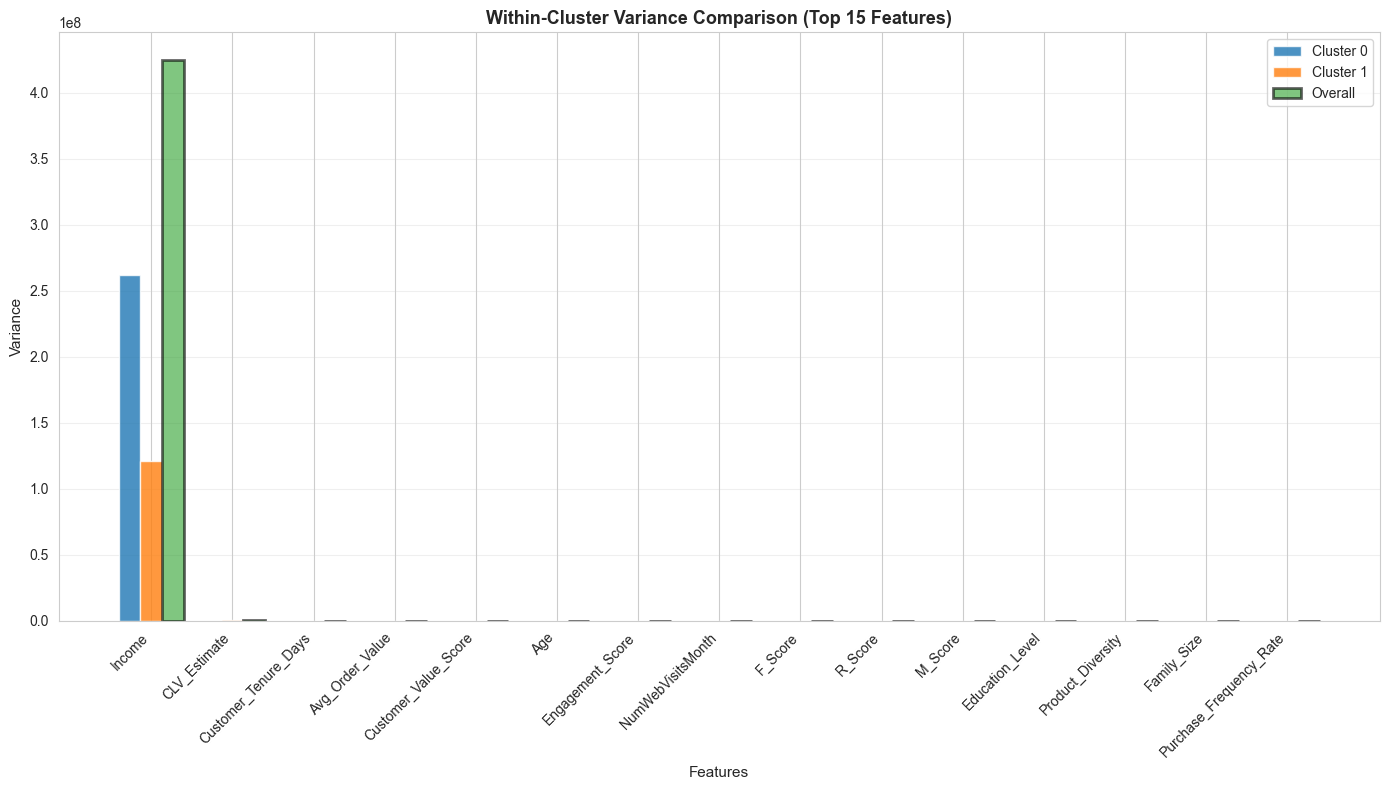

In [15]:
#  WITHIN-CLUSTER VARIANCE ANALYSIS
within_cluster_variance = pd.DataFrame()

for i in range(n_clusters):
    cluster_data = df[df['Final_ML_Cluster'] == i][feature_cols]
    variance = cluster_data.var()
    within_cluster_variance[f'Cluster_{i}'] = variance

# Calculate overall variance
within_cluster_variance['Overall'] = df[feature_cols].var()

# Select top 15 features with highest overall variance
top_variance_features = within_cluster_variance['Overall'].nlargest(15).index

# Plot variance comparison
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(top_variance_features))
width = 0.8 / (n_clusters + 1)

for i in range(n_clusters):
    offset = width * (i - n_clusters/2)
    ax.bar(x + offset, within_cluster_variance.loc[top_variance_features, f'Cluster_{i}'],
           width, label=f'Cluster {i}', alpha=0.8)

ax.bar(x + width * n_clusters/2, within_cluster_variance.loc[top_variance_features, 'Overall'],
       width, label='Overall', alpha=0.6, edgecolor='black', linewidth=2)

ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Variance', fontsize=11)
ax.set_title('Within-Cluster Variance Comparison (Top 15 Features)', 
             fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(top_variance_features, rotation=45, ha='right')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_within_cluster_variance.png', 
            dpi=300, bbox_inches='tight')
plt.show()


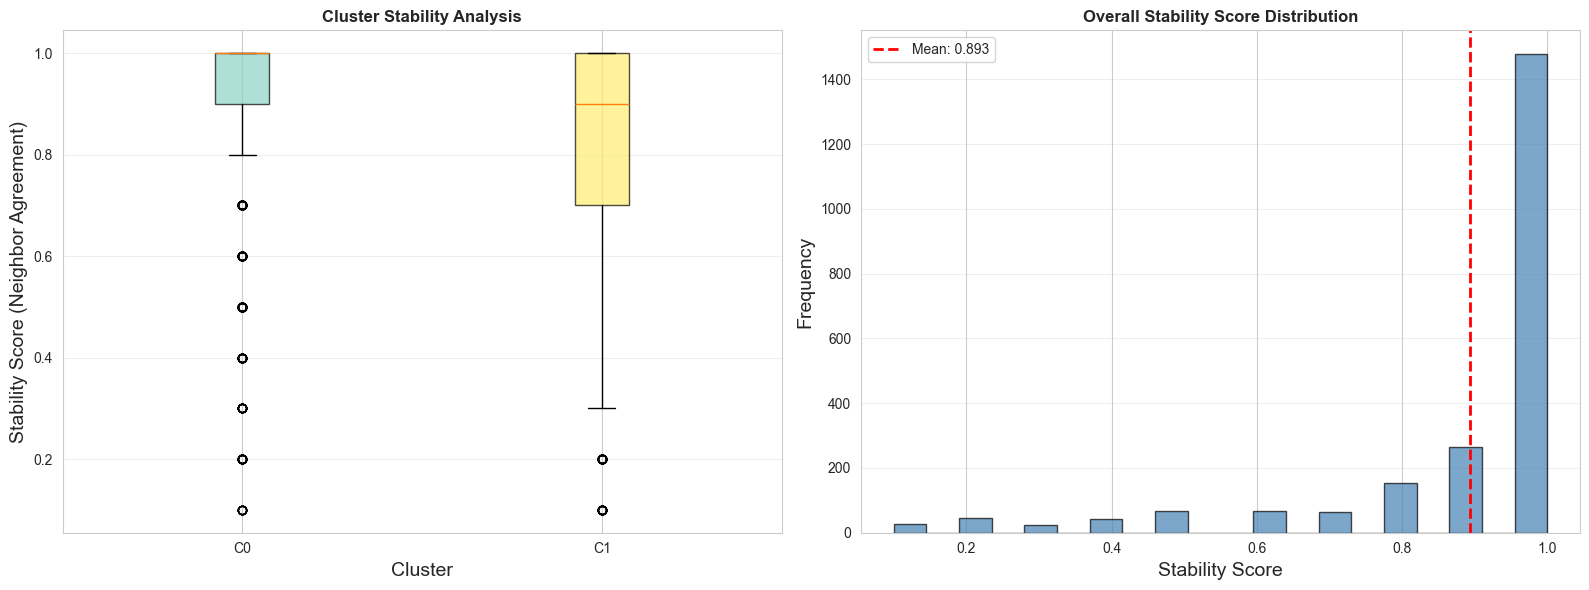


Cluster Stability Summary:
----------------------------------------------------------------------
Cluster 0: 0.926
Cluster 1: 0.815

Overall Average Stability: 0.893
✓ Clusters are very stable


In [16]:
#  CLUSTER STABILITY ANALYSIS
nn = NearestNeighbors(n_neighbors=10)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# For each point, check if neighbors are in same cluster
stability_scores = []
for i in range(len(clusters)):
    same_cluster = (clusters[indices[i]] == clusters[i]).sum()
    stability_scores.append(same_cluster / 10)

df['Stability_Score'] = stability_scores

# Plot stability by cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stability distribution by cluster
stability_by_cluster = [df[df['Final_ML_Cluster'] == i]['Stability_Score'].values 
                        for i in range(n_clusters)]
bp = ax1.boxplot(stability_by_cluster, labels=[f'C{i}' for i in range(n_clusters)],
                 patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_xlabel('Cluster')
ax1.set_ylabel('Stability Score (Neighbor Agreement)')
ax1.set_title('Cluster Stability Analysis', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')

# Overall stability histogram
ax2.hist(stability_scores, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=np.mean(stability_scores), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(stability_scores):.3f}')
ax2.set_xlabel('Stability Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Overall Stability Score Distribution', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_cluster_stability.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nCluster Stability Summary:")
print("-" * 70)
for i in range(n_clusters):
    cluster_stability = df[df['Final_ML_Cluster'] == i]['Stability_Score'].mean()
    print(f"Cluster {i}: {cluster_stability:.3f}")

avg_stability = np.mean(stability_scores)
print(f"\nOverall Average Stability: {avg_stability:.3f}")

if avg_stability > 0.8:
    print("✓ Clusters are very stable")
elif avg_stability > 0.6:
    print("✓ Clusters show good stability")
else:
    print("⚠ Clusters show moderate stability - some boundary cases exist")



Top 15 Features for Cluster Separation (ANOVA F-statistic):
----------------------------------------------------------------------
Is_High_Spender                         : F= 4911.50 (p=0.0000) ***
CLV_Estimate                            : F= 2962.24 (p=0.0000) ***
M_Score                                 : F= 2554.06 (p=0.0000) ***
Income                                  : F= 2063.52 (p=0.0000) ***
Avg_Order_Value                         : F= 1996.10 (p=0.0000) ***
Has_Children                            : F= 1671.96 (p=0.0000) ***
Customer_Value_Score                    : F= 1079.52 (p=0.0000) ***
Engagement_Score                        : F=  943.34 (p=0.0000) ***
NumWebVisitsMonth                       : F=  826.41 (p=0.0000) ***
F_Score                                 : F=  794.20 (p=0.0000) ***
Family_Size                             : F=  760.45 (p=0.0000) ***
Campaign_Acceptance_Rate                : F=  483.12 (p=0.0000) ***
Is_Campaign_Responder                   : F=  366.67

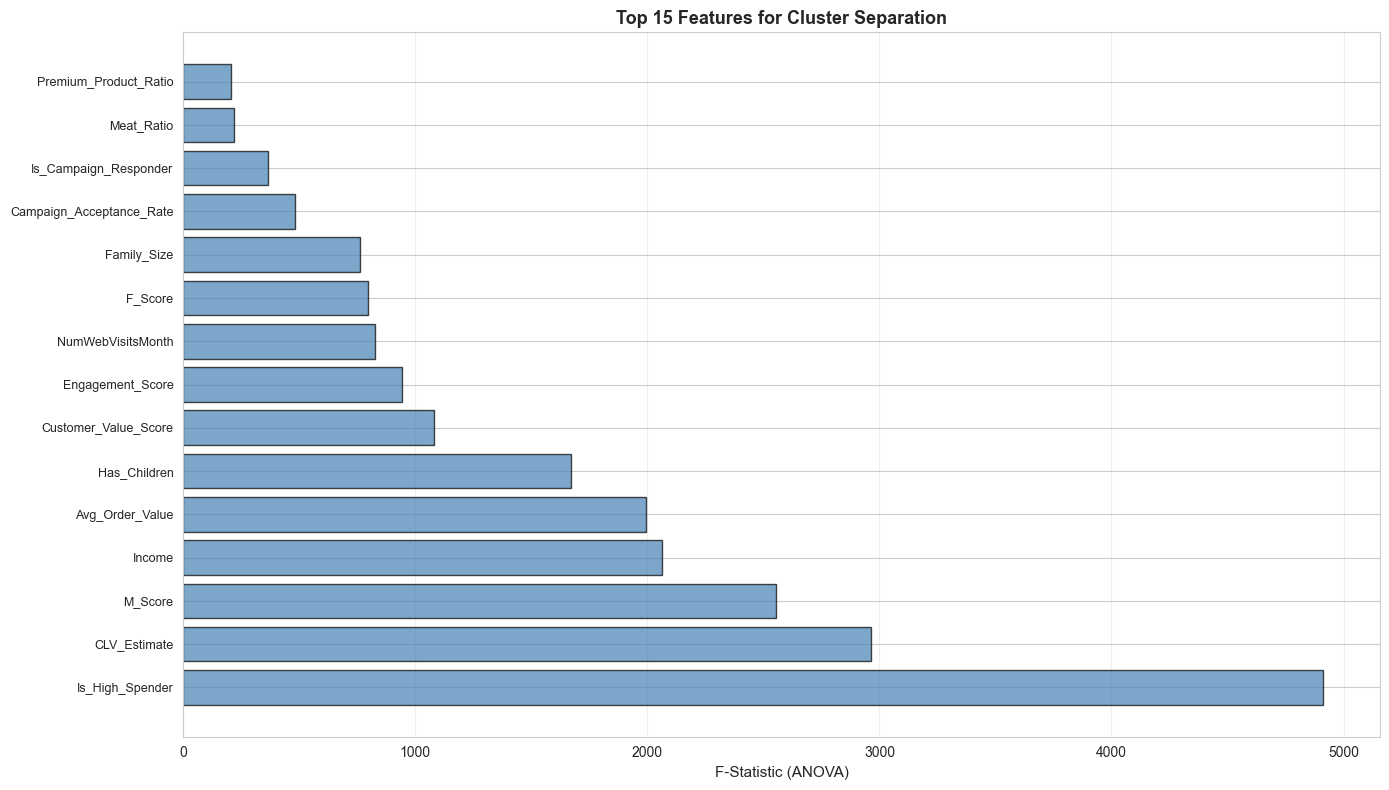

In [17]:
# FEATURE CORRELATION WITH CLUSTERS
from scipy.stats import f_oneway

feature_importance = []
for feat in feature_cols:
    cluster_groups = [df[df['Final_ML_Cluster'] == i][feat].values for i in range(n_clusters)]
    f_stat, p_value = f_oneway(*cluster_groups)
    feature_importance.append({
        'Feature': feat,
        'F_Statistic': f_stat,
        'P_Value': p_value
    })

feature_importance_df = pd.DataFrame(feature_importance).sort_values('F_Statistic', ascending=False)

print("\nTop 15 Features for Cluster Separation (ANOVA F-statistic):")
print("-" * 70)
for i, row in feature_importance_df.head(15).iterrows():
    significance = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
    print(f"{row['Feature']:40s}: F={row['F_Statistic']:8.2f} (p={row['P_Value']:.4f}) {significance}")

# Visualize feature importance
fig, ax = plt.subplots(figsize=(14, 8))
top_15_features = feature_importance_df.head(15)
ax.barh(range(15), top_15_features['F_Statistic'], color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(15))
ax.set_yticklabels(top_15_features['Feature'], fontsize=9)
ax.set_xlabel('F-Statistic (ANOVA)', fontsize=11)
ax.set_title('Top 15 Features for Cluster Separation', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step6_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
#  SAVE EVALUATION RESULTS
df.to_csv('D://My projects/customer_segmentation_project/data/processed/step6_evaluated_clusters.csv', index=False)
print("✓ Saved data with stability scores")

# Create comprehensive evaluation report
evaluation_report = {
    'Metric': [
        'Silhouette Score',
        'Calinski-Harabasz Score',
        'Davies-Bouldin Score',
        'Inertia (WCSS)',
        'Number of Clusters',
        'Total Customers',
        'Average Cluster Size',
        'Largest Cluster',
        'Smallest Cluster',
        'Balance Ratio',
        'Average Stability Score',
        'Number of Features'
    ],
    'Value': [
        f'{silhouette_avg:.4f}',
        f'{calinski_score:.2f}',
        f'{davies_bouldin:.4f}',
        f'{inertia:.2f}',
        n_clusters,
        len(df),
        f'{avg_size:.0f}',
        f'{max_size} ({max_size/len(df)*100:.1f}%)',
        f'{min_size} ({min_size/len(df)*100:.1f}%)',
        f'{balance_ratio:.2f}',
        f'{avg_stability:.3f}',
        len(feature_cols)
    ],
    'Interpretation': [
        'Higher is better (max=1)',
        'Higher is better',
        'Lower is better (min=0)',
        'Lower is better',
        '-',
        '-',
        '-',
        '-',
        '-',
        'Closer to 1 is better',
        'Closer to 1 is better',
        '-'
    ]
}

evaluation_df = pd.DataFrame(evaluation_report)
evaluation_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step6_evaluation_summary.csv', index=False)
print("✓ Saved evaluation summary report")

# Save cluster-wise metrics
cluster_metrics = pd.DataFrame({
    'Cluster': range(n_clusters),
    'Size': cluster_sizes.values,
    'Percentage': (cluster_sizes.values / len(df) * 100).round(2),
    'Avg_Silhouette': [silhouette_vals[clusters == i].mean() for i in range(n_clusters)],
    'Avg_Stability': [df[df['Final_ML_Cluster'] == i]['Stability_Score'].mean() for i in range(n_clusters)]
})
cluster_metrics.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step6_cluster_metrics.csv', index=False)
print("✓ Saved cluster-wise metrics")

# Save feature importance
feature_importance_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step6_feature_importance.csv', index=False)
print("✓ Saved feature importance analysis")

✓ Saved data with stability scores
✓ Saved evaluation summary report
✓ Saved cluster-wise metrics
✓ Saved feature importance analysis


In [20]:
print("\n" + "="*70)
print("MODEL EVALUATION SUMMARY")
print("="*70)

print(f"\n📊 Clustering Quality Metrics:")
print(f"   Silhouette Score:        {silhouette_avg:.4f}")
print(f"   Calinski-Harabasz Score: {calinski_score:.2f}")
print(f"   Davies-Bouldin Score:    {davies_bouldin:.4f}")
print(f"   Average Stability:       {avg_stability:.3f}")

print(f"\n📈 Cluster Distribution:")
print(f"   Number of clusters:      {n_clusters}")
print(f"   Balance ratio:           {balance_ratio:.2f}")
print(f"   Size range:              {min_size} - {max_size} customers")

print(f"\n🔍 Feature Analysis:")
print(f"   Total features used:     {len(feature_cols)}")
print(f"   Most important feature:  {feature_importance_df.iloc[0]['Feature']}")
print(f"   F-statistic:             {feature_importance_df.iloc[0]['F_Statistic']:.2f}")

print("\n💡 Recommendations:")
if silhouette_avg > 0.5 and balance_ratio > 0.3 and avg_stability > 0.7:
    print("   ✓ Clustering quality is good - proceed to next steps")
elif silhouette_avg < 0.3:
    print("   ⚠ Consider trying different number of clusters")
elif balance_ratio < 0.2:
    print("   ⚠ Clusters are imbalanced - may need refinement")
elif avg_stability < 0.6:
    print("   ⚠ Some boundary cases exist - review cluster assignments")
else:
    print("   ✓ Reasonable clustering quality - proceed with caution")

print("\n✓ Step 6 completed successfully!")
print("="*70)


MODEL EVALUATION SUMMARY

📊 Clustering Quality Metrics:
   Silhouette Score:        0.3975
   Calinski-Harabasz Score: 2064.24
   Davies-Bouldin Score:    0.7016
   Average Stability:       0.893

📈 Cluster Distribution:
   Number of clusters:      2
   Balance ratio:           0.41
   Size range:              653 - 1576 customers

🔍 Feature Analysis:
   Total features used:     28
   Most important feature:  Is_High_Spender
   F-statistic:             4911.50

💡 Recommendations:
   ✓ Reasonable clustering quality - proceed with caution

✓ Step 6 completed successfully!
